# Statistical Testing Templates for CPTAC Data

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

print(phos)

#Try Looking at all proteins, not just interacting proteins
all_proteins = list(proteomics.columns.values)
#print(len(all_proteins))
#print(all_proteins)

idx   AAAS-S495  AAAS-S541  AAAS-Y485  AACS-S618  AAED1-S12  AAGAB-S310  \
S001        NaN        NaN        NaN    -0.8810    -1.8100         NaN   
S002        NaN        NaN        NaN        NaN     0.0840         NaN   
S003   -0.20200        NaN        NaN        NaN    -1.8800         NaN   
S004    0.25000        NaN        NaN        NaN        NaN         NaN   
S005   -0.00200        NaN     -0.407        NaN        NaN         NaN   
S006    0.55600    -0.0461        NaN        NaN     0.9410         NaN   
S007        NaN        NaN        NaN        NaN     0.0796         NaN   
S008    0.30000        NaN        NaN    -0.3710    -1.1400         NaN   
S009    0.49000        NaN        NaN        NaN        NaN         NaN   
S010   -0.23100     0.0108        NaN        NaN     0.2420         NaN   
S011    0.26800        NaN        NaN        NaN    -0.1120         NaN   
S012   -0.06200        NaN        NaN     1.8600    -1.4000         NaN   
S013   -1.49000        Na

## t-test for effects of all mutations combined
<b>Note:</b> You can put any number of proteins in the list and it will compare that gene with the protein levels of all of them

### List of interacting proteins (according to STRING and Uniprot)

In [4]:
#Build the protein list; this may have only a single protein if desired
#protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PKC', 'MTOR', 'S6K', 'MAPK', 'ERBB3', 'P85A', 'P55G', 'CDK5']
protList = all_proteins

In [5]:
gene = 'PIK3CA'
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[:100]
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [7]:
print(significant_proteins)
print(significant_pvals)

[]
[]


### Test for phosphorylation levels (mutation in any gene with phosphorylation of any protein)

In [8]:
#List of proteins (will test all phosphorylation sites on these proteins)
phosProtList = protList

In [9]:
sites = phos.columns
p_values = []
site_names = []

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     



#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'

print(p_values)
print(site_names)

sum = 0
for p in p_values:
    sum += p
avg = sum/len(p_values)

print("AVG p_val = ", avg)
        


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Seeing significance of P values using bonferroni correction

In [10]:
threshold_pval = .05/len(site_names)
print("threshold_pval: ", threshold_pval)
bonferonni_corrected_pvals = list()
bonferonni_sig_sites = list()
for ind in range(0, len(p_values)):
    if p_values[ind] <= threshold_pval:
        bonferonni_corrected_pvals.append(p_values[ind])
        bonferonni_sig_sites.append(site_names[ind])
        
        
bf_significant_vals = dict(zip(bonferonni_sig_sites, bonferonni_corrected_pvals))

threshold_pval:  5.024469164832736e-07


### Print signifcant p-values

In [23]:
#print("\nSignificant P-values from Bonferroni: ", bonferonni_corrected_pvals)
#print("\nSignificant Sites from Bonferroni: ", bonferonni_sig_sites)
#sortedkeys = sort(bf_significant_vals.keys())
#for key in sortedkeys:
#    print (key, bf_significant_vals[key])
#print("\nSignificant values: ", bf_significant_vals)

for key in sorted(bf_significant_vals):
    #print(%s: %s % (key, bf_significant_vals[key]))
    print(key, bf_significant_vals[key])

print(len(bonferonni_sig_sites))
print(len(bonferonni_corrected_pvals))
print(len(site_names))


indexMin = bonferonni_corrected_pvals.index(min(bonferonni_corrected_pvals))

#print("Min P-val: ", bonferonni_corrected_pvals[index_min])
#print("Site name at min: ", bonferonni_sig_sites[index_min])

AHNAK-S4908 5.498611238582909e-08
AHNAK-S5448 2.8485316766016553e-07
AHNAK-S793 2.2505885402871095e-07
AKAP12-S629 1.9288016516412425e-08
AKAP12-S651 3.3425679957238745e-07
AKAP12-T1116 4.403072547454285e-07
AKAP12-T646 2.0898925251561834e-07
AKAP12-T649 3.3045370792446175e-08
ANK2-S3909 3.917724263221153e-07
ANKZF1-S361 1.7654663022118694e-08
ANKZF1-S56 2.1137840430720068e-07
AP3B2-S272 4.013333847930438e-09
ARHGEF25-S525 1.2785903810683652e-07
ARHGEF25-S595 3.3936904760010647e-07
ATXN2-S684 3.200133729361071e-08
BMS1-S552 1.2205501701833273e-07
CAMSAP2-S1148 1.1601942160543228e-07
CAMSAP3-S361 8.210331338058326e-08
CAMSAP3-S514 1.228431382330733e-08
CAMSAP3-S581 3.3283246779299966e-07
CAMSAP3-S807 2.3468483607334442e-07
CAV2-S20 2.0497365481071782e-08
CAV2-S23 2.498797688922786e-09
CAVIN1-S36 4.134347013685614e-07
CAVIN2-S27 8.365211497249967e-09
CCDC186-S740 3.63886184215182e-08
CDC42EP1-S353 1.3445891373900883e-07
CDH11-S714 2.7892018806029103e-08
CUX1-S1344 3.4710998820992616e-07


### Use FDR Correction

In [17]:
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]
significant_vals = dict(zip(significant_sites, significant_pvalues))


print("\nSignificant P-vals (FDR): ", significant_pvalues)
print("\nSignificant sites (FDR): ", significant_sites)
print("\nSignificant values (FDR): ", significant_vals)

print(len(significant_sites))


Significant P-vals (FDR):  [0.03635796 0.01466716 0.04649853 ... 0.00531754 0.0104003  0.0377151 ]

Significant sites (FDR):  ['AAAS-S495' 'AAED1-S12' 'ABCC1-S919' ... 'ZYX-S508' 'ZYX-Y172'
 'ZZEF1-S2444']

Significant values (FDR):  {'AAAS-S495': 0.0363579600380938, 'AAED1-S12': 0.014667157212490149, 'ABCC1-S919': 0.04649853020901749, 'ABCC1-S921': 0.020267302763689845, 'ABCF1-S166': 0.009520118650746152, 'ABCF1-S22': 0.006105975677546533, 'ABCF3-S157': 0.016897767192590583, 'ABI1-S216': 0.022693920974653187, 'ABI1-S225': 0.03042139400525824, 'ABI1-T200': 0.0076430525397573525, 'ABI2-S183': 0.009910512564950418, 'ABI2-S233': 0.008306610888358358, 'ABI2-S368': 0.0002315417731222978, 'ABL1-S199': 0.03601633069448748, 'ABL1-S824': 0.010129649983274635, 'ABL1-S828': 0.0008698074034836522, 'ABL1-T798': 0.005213562782018359, 'ABL1-Y204': 0.028340860291850095, 'ABLIM1-S367': 0.001512863969445628, 'ABLIM1-S586': 0.033788800308559006, 'ABLIM1-S587': 0.015915736573355054, 'ABLIM2-S279': 0.0438

### Plot phosphorylation levels and gene mutation
<b>Note:</b> There may be fewer data points due to NA values

INDEX MIN:  687  PVAL:  4.3398106054762676e-05
SIGNIFICANT SITES LENGTH:  12163


[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

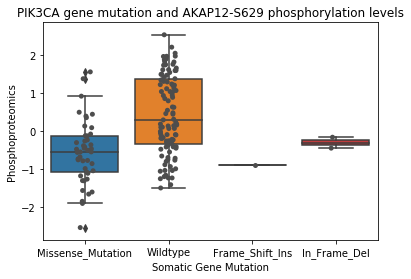

In [28]:
#Specify the gene and the site; you may use a string to specify the site or reference the significant results above

index_min = significant_pvalues.tolist().index(min(significant_pvalues))
print("INDEX MIN: ", index_min, " PVAL: ", significant_pvalues[index_min])
gene = 'PIK3CA'
#site = significant_sites[index_min]
site="AKAP12-S629"
print("SIGNIFICANT SITES LENGTH: ", len(significant_sites))

#print(somatic_mutations)

#Build the dataframe for plotting
#genedf = somatic_mutations[gene].to_frame()
genedf = CPTAC.compare_mutations(phos, site, gene)

#print(genedf)
#sites = phos.filter(regex=site)
#genedf = genedf.add(sites, fill_value=0)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")